# Managing pins

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
Headings.h1('Welcome to Qiskit Metal')

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

First we create some transmon pockets to have a number of pins generated for use.

In [4]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict( 
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.4mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.9mm', orientation = '90', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.4mm', pos_y='+0.0mm', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.9mm', orientation = '90', **options))

## Rebuild the design
gui.rebuild()
gui.autoscale()

Selecting the different components via the GUI shows the pins said component has. You can also see this via;

In [5]:
design.components.Q1.pins.keys()

dict_keys(['a', 'b', 'c', 'd'])

Each pin contains a dictionary of information which can be used by other components or renderers. 

In [6]:
design.components.Q1.pins.a

{'points': [array([2.825, 0.2  ]), array([2.825, 0.19 ])],
 'middle': array([2.825, 0.195]),
 'normal': array([1., 0.]),
 'tangent': array([0., 1.]),
 'width': 0.01,
 'gap': 0.006,
 'chip': 'main',
 'parent_name': 1,
 'net_id': 0,
 'length': 0}

We can pass these pins into some components to auto generate connections, such as CPW lines.

In [7]:
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

c1 = RouteStraight(design, 'c1', type="Route", options=dict(pin_inputs=dict(start_pin = dict(component = 'Q1',
                                                                               pin = 'd'),
                                                            end_pin=dict(component = 'Q2',
                                                                                pin = 'c'))))
gui.rebuild()
gui.autoscale()

The example CPW also automatically generates it's own pins based on the pin inputs it was given. This is to allow for such a component to not
be destroyed if the component it is attached to is deleted.

In [8]:
design.components.c1.pins

{'start': {'points': array([[ 1.975, -0.19 ],
         [ 1.975, -0.2  ]]),
  'middle': array([ 1.975, -0.195]),
  'normal': array([ 1., -0.]),
  'tangent': array([ 0., -1.]),
  'width': 0.01,
  'gap': 0.006,
  'chip': 'main',
  'parent_name': 5,
  'net_id': 3,
  'length': 0},
 'end': {'points': array([[ 0.2  , -0.475],
         [ 0.19 , -0.475]]),
  'middle': array([ 0.195, -0.475]),
  'normal': array([-0., -1.]),
  'tangent': array([-1.,  0.]),
  'width': 0.01,
  'gap': 0.006,
  'chip': 'main',
  'parent_name': 5,
  'net_id': 4,
  'length': 0}}

We can also see what active connections there are from the netlist. Pins that share the same net_id indicate they are connected. Pins that are not on the net list are currently open.

In [9]:
design.net_info

,net_id,component_id,pin_name
0,3,1,d
1,3,5,start
2,4,2,c
3,4,5,end


What happens if we try to pass in a component/pin combo that doesn't exist?

In [10]:
#A component that doesn't exist
c2 = RouteStraight(design, 'c2', type="Route", options=dict(pin_inputs = dict(start_pin = dict(component = 'NotReallyHere',
                                                                               pin = 'd'),
                                                            end_pin =dict(component = 'Q2',
                                                                                pin = 'a'))))

04:25PM 48s WARNING [__init__]: Component NotReallyHere does not exist. c2 has not been built. Please check your pin_input values.


In [11]:
#A pin that doesn't exist
c3 = RouteStraight(design, 'c3', type="Route", options=dict(pin_inputs = dict(start_pin = dict(component = 'Q1',
                                                                               pin = 'NotReallyHere'),
                                                            end_pin =dict(component = 'Q2',
                                                                                pin = 'a'))))

04:25PM 48s WARNING [__init__]: Pin NotReallyHere does not exist in component Q1. c3 has not been built. Please check your pin_input values.


Or if try to pass in a pin that is already connected.

In [12]:
c4 = RouteStraight(design, 'c4', type="Route", options=dict(pin_inputs = dict(start_pin = dict(component = 'Q1',
                                                                               pin = 'b'),
                                                            end_pin =dict(component = 'Q2',
                                                                                pin = 'c'))))

04:25PM 48s WARNING [__init__]: Pin c of component Q2 is already in use. c4 has not been built. Please check your pin_input values.


pin_inputs is the default dictionary for passing pins into a component, **BUT** how the dictionary is structured is component dependent. Using the above structure (eg. start_pin, end_pin) is suggested for any 2 port type connection, but you should always check the documentation for the specific component you are wanting to use.

In [13]:
Headings.h1('CPW Examples')

An example set showing some current functional CPW components, including both simple auto-routing and meandering

In [14]:
design.delete_all_components()

In [15]:
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.framed_path import RouteFramed
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [16]:
open_start_straight = OpenToGround(design,'Open_straight_start',options=Dict(pos_x='0um',pos_y='0um',orientation = '-90'))
open_end_straight = OpenToGround(design,'Open_straight_end',options=Dict(pos_x='0um',pos_y='1500um',orientation = '90'))

open_start_auto = OpenToGround(design,'Open_auto_start',options=Dict(pos_x='250um',pos_y='0um',orientation = '-90'))
open_end_auto = OpenToGround(design,'Open_auto_end',options=Dict(pos_x='250um',pos_y='1500um',orientation = '0'))

open_start_meander = OpenToGround(design,'Open_meander_start',options=Dict(pos_x='1000um',pos_y='0um',orientation = '-90'))
open_end_meander = OpenToGround(design,'Open_meander_end',options=Dict(pos_x='1000um',pos_y='1500um',orientation = '90'))

testStraight = RouteStraight(design,'straightTest',options=Dict(pin_inputs=Dict(
                                                                    start_pin=Dict(
                                                                        component = 'Open_straight_start',
                                                                        pin = 'open'),
                                                                    end_pin=Dict(
                                                                        component = 'Open_straight_end',
                                                                        pin = 'open')
                                                                    )))

testAuto = RouteFramed(design,'autoTest',options=Dict(pin_inputs=Dict(
                                                                    start_pin=Dict(
                                                                        component = 'Open_auto_start',
                                                                        pin = 'open'),
                                                                    end_pin=Dict(
                                                                        component = 'Open_auto_end',
                                                                        pin = 'open')
                                                                    )))

testMeander = RouteMeander(design,'meanderTest',options=Dict(pin_inputs=Dict(
                                                                    start_pin=Dict(
                                                                        component = 'Open_meander_start',
                                                                        pin = 'open'),
                                                                    end_pin=Dict(
                                                                        component = 'Open_meander_end',
                                                                        pin = 'open')
                                                                    )))
gui.rebuild()
gui.autoscale()

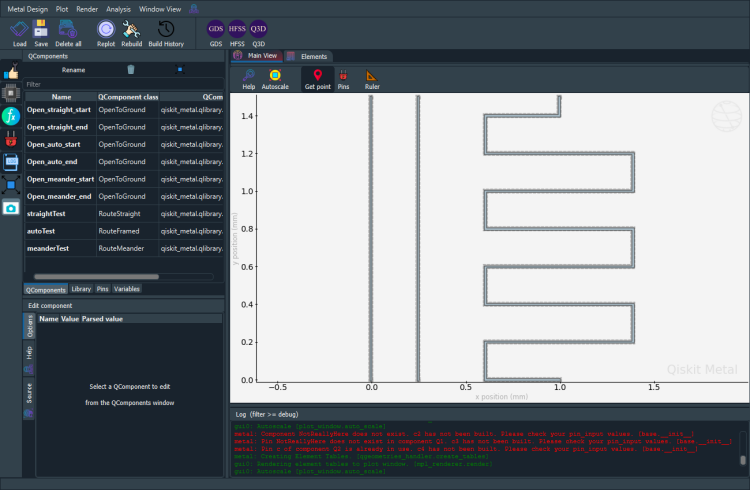

In [17]:
gui.screenshot()